# Forecasting Australia's 2019 Election with PyMC3
#### Martin Burgess


Slides: 

Hi, my name's Martin, I'm excited to be here. This is my first time at PyCon and my first time speaking.

I'm a data scientist who's passionate about using information for good. I just started a new job as a consultant at Nous, where we work with clients to use their data and have a positive influence. 

Late last year and earlier this year I built a forecast of the 2019 Australian federal election as a personal project to develop my understanding of Bayesian statistics. This forecast was based on publicly available polling data, historical election results and used the probabilistic programming language PyMC3 and today I'm going to take you behind the scenes and show you how it works. 

## Motivation
After my talk, I hope you will:
1. understand some the benefits of _probabilistic_ forecasting
2. see how easy it is to build probabilistic models using PyMC3

Before I jump in I wanted to give you a clear idea of what I hope you'll get out of my talk. First, I hope to show you some of the benefits of probabilistic forecasting. In my view probabilistic forecasting is a great way to approach a lot of different problems. It helps you understand the uncertainty in what you are modelling and make decisions based on your forecast

The second thing I hope you'll see is how easy it is to build models in PyMC3 so that you'll be able to get started yourself. 

I do also want to say, while I have an interest in politics and we're using an election as our guide, hopefully this is presented so that you can take what I'm talking about an apply to your own interesting problems. 

## Overview
1. Probabilistic forecasting
2. Defining the problem (Australian election primer)
3. Building a model in PyMC3

## Overview
1. Probabilistic forecasting <font color=grey>
2. Defining the problem (Australian election primer)
3. Building a model in PyMC3</font>

### What is probabilistic forecasting?

Rather than trying to identify the single most likely outcome, probabilistic forecasting tries to estimate the _relative probabilities of all possible outcomes_.

Bayes' theorem describes the conditional probability of an event based on data as well as prior information or beliefs about the event or conditions related to the event.

<table style="float:right; width: 50%">
<tr>
    <td> <img style="float: left; width: 90%" src="../img/weather-1.png"> </td>
    </tr>
</table> 
<br>
Most weather forecasts are probabilistic. 

Instead of just identifying the most likely outcome they forecast the relative probabilities of the two possible outomes (30% rain vs. 70% no rain). 

A great example of a probabilistic forecast that we see regularly are the "chance of rain" element of a weather forecast. This element is probabilistic in that it is not just stating the most likely outcome: here it would be "No rain" but it is giving you the relative probabilities of the two different outcomes "30% chance of rain, and (an implied) 70% chance of no rain". 

Out of interest, how many people here would take a raincoat or an umbrella if they were going for a walk where the forecast had a 30% chance of rain? Please raise your hand if you would. 


### Why forecast probabilistically? 
#### 1. The future is uncertain. 
<b>Sometimes something other than the _most likely_ outcome happens. </b>

<br>
Probabilistic forecasting can give you a really clear idea of uncertainty associated with your prediction. 

Why would we want to forecast probabilistically? 

In my view, a really key reason for forecasting probabilistically is that the future is uncertain. We don't know what will happen. As scientists and data scientists we can use data to understand what has happened in the past, create a model, and try and predict the future but we can't to do that perfectly. We don't have access to every piece of information we need and even if we did we might not be able to identify all the relationships perfectly. 

When we're thinking about the future, if our focus is just to identify the most likely outcome, we will often end up picking something that doesn't happen. Outcomes other than the most likely outcome happen all the time. Outcomes other than the most likely outcome happen all the time. 

Sometimes it rains when there is a 70% chance that it won't rain. Sometimes Donald Trump wins an election. Simetimes you guess the correct answer in a multiple choice test. These are all examples, I would say, of the most likely outcome NOT happening. 


### 1. The future is uncertain

If we just forecast the most likley outcome, we don't have a clear sense of how much more likely it is than other outcomes. 
<table style="height:50%">
<tr>
    <td style="width: 45%"> <img style="float:right; width:100%" src="../img/newspoll.png"> </td> 
    <td style="width:10%; font-size:30px; text-align:center"> vs. </td>
    <td style="width: 45%"> <img style="float:left; width:100%" src="../img/buckleys.png"> </td>
    </tr>
</table>

To illustrate this point, I want to compare two forecast of the previous election. 

On the left hand side is an screenshot taken from the Newspoll website. I don't mean to pick on them, a lot of forecasts do something similar. Before the election they built a forecast the next election and identified what they thought was the most likely outcome. The Coalition would win 65 seats, Labor 80 seats. Another way to represent this is to say the ALP would win 15 more seats than the Coalition. 

On the right hand side is a screenshot from my forecast on buckleysandnone.com. Across the x-axis I have all the different possible margins between the two parties. On the y-axis is a representation of the relatively likelihoods of those different possible outcomes. This is called a probability mass function. In the bubble you can see the outcome Newspoll predicted, the ALP winning 15 more seats than the Coalition, highlighted with a percentage associated with it. We gave that outcome a 5.1% chance of occuring. We gave the likelihood of the ALP winnning even more seats than the Coalition a slightly lower probability. We also gave the probability of the margin between the two parties being closer than 15 a higher probability. Our highest likelihoods were closer to the actual outcome of the Coalition winning 9 more seats than the ALP. I'm less interested in that and more interested in demonstrating that using probabilistic forecasting you can see the relative likelihoods of different outcomes and see the total sphere of what is possible. 

### 2. Make better decisions

Understanding uncertainty and forecasting probabilistically can help you make better decisions. 

You can identify how much *much likely* one outcome is from another, instead of just the most likely outcome. 
    


<br>
<table style="width:50%">
<tr>
    <td style="width: 50%"> <img style="width:100%" src="../img/bet.png"> <img style="width:100%" src="../img/money.gif"> </td>    </tr>
</table>

## Why forecast probabilistically?

1. The future is uncertain
2. Helps you make decisions
3. Assumptions are clear

By forecasting probabilistically, you have a much better idea of what could possibly happen that you would if you just identified the most likely outcome. You can also use the probabilities you've generated to help you make decisions. 

Our forecasted probabilities changed throughout the election campaign. At the absolute highest we gave the ALP a 70% chance of winning. If you had a 70% chance of winning an extra 230,000 dollars or a 30% chance of losing 1 million dollars. Hopefully you'd choose the right option and not bet at all! 

There are three really quick reasons to forecast probabilistically
1. The future is uncertain. Probabilistic forecasting helps to estimate uncertainty.
2. Assigning probabilities to different outcomes helps you make decisions. 
3. Any assumptions you have are explicit. 

## Overview
1. <font color=grey>Probabilistic forecasting </font>
2. Defining the problem (Australian election primer)
3. <font color=grey>Building a model in PyMC3</font>

### Who will win the 2019 Australian Federal election?

<br>
House of Representatives has 151 seats. 

<table style="float:right; width:30%">
<tr>
    <td style="width: 100%"> <img style="width:100%" src="../img/seats.svg"></td>
    </tr>
</table>

Three primary outcomes:
1. <p style="color:#e53440">ALP win majority (>=76 seats)</p>
2. <p>Minority government (neither party wins 76 seats)</p>
3. <p style="color:#1c4f9c">Coalition win majority (>= 76 seats) </p>


<img src="../img/model-overview-seats2winner.svg">


I want to give you a really quick primer on elections in Australia so that we are all on the same page. In Australia, who wins government is decided by the House of Representatives, which, this election, was made up of 151 seats. This means to form a majority government either of the two major parties (the ALP or the Coalition) have to win 76 or more seats. It is possible that neither party wins 76 seats, for example the ALP could win 75 seats, the Coalition could win 75 seats and one could be held be a crossbench MP. This would be a minority government where one of the major parties makes  a deal with that crossbencher for their support. 

In order to predict who will win government we need to predict how many seats is going to win. 

<table style="float:right; width:40%">
<tr>
    <td> <img style="width:100%" src="../img/ballot3.png"></td>
    </tr>
</table>

### We'll use the two-party preferred vote

Australia has preferential voting.

<b>TPP Margin = Coalition TPP - ALP TPP</b>

<table style="float:left;width:50%">
    <tr>
        <td>Coalition TPP</td><td>ALP TPP</td><td>TPP Margin</td>
    </tr>
        <tr>
        <td>0.55</td><td>0.45</td><td>0.10</td>
    </tr>
        <tr>
        <td>0.475</td><td>0.525</td><td>-0.05</td>
    </tr>

<img src="../img/model-overview-full.svg">

So we've got an idea of how to predict the eventual winner, we'll estimate the number of seats the ALP, the Coalition, and the Crossbench will win. 

To predict the number of seats the different groups will win we're going to use the two-party preferred vote margin. 

In Australia, we have what is called "preferential" voting, this means voters number candidates from 1 (their most favoured candidate) to the end of the list. 

When votes are being counted the candidate who receive the fewest number of first preference votes is eliminated. The ballots of those who put the eliminated candidate first are then re-examined and the second preferences distributed. This process of candidates being eliminated and preferences being distributed continues until one candidate has more than 50% of the vote. 

Rather than looking at who voters put first on their ballots, the two-party preferred vote is a measure of preference between the two major parties, the ALP and the Coalition. It's 

## Overview
1. <font color=grey>Probabilistic forecasting
2. Defining the problem (Australian election primer)</font>
3. Building a model in PyMC3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
import theano.tensor as tt
import arviz as az
# %matplotlib inline

## Building a model in PyMC3

<img style="width:60%" src="../img/PyMC3_banner.svg">

In [3]:
import pymc3 as pm

Introduce PyMC 

> PyMC3 is a probabilistic programming package for Python that allows users to fit Bayesian models using a variety of numerical methods... 
> PyMC3 strives to make Bayesian modeling as simple and painless as possible, allowing users to focus on their scientific problem, rather than on the methods used to solve it.

PyMC3 uses a sampling method called Markov Chain Monte Carlo, that I don't have time (or the knowledge) to speak about here. You'll see as I run some of the code this sampling can take a second or two. 

### Bayesian Method
<img style="width:100%" src="../img/bayes-workflow.svg">

For PyMC3 to work we have to specify 3 things. 

> In Bayesian statistics, a prior probability distribution of an uncertain quantity is the probability distribution that would express one's beliefs about this quantity before some evidence (or data) is taken into account.

These are our assumptions.

> In statistics, the likelihood function (often simply called likelihood) expresses how likely particular values of statistical parameters are for a given set of observations.

### Step One: Aggregate polls (bayesian parameter estimation)

<img src="../img/model-overview-2.svg">

#### Polls predicted a Labor victory

Mean polling two-party preferred margin: -0.006 (ALP Win)
Actual two-party preferred margin: 0.031 (COA Win)


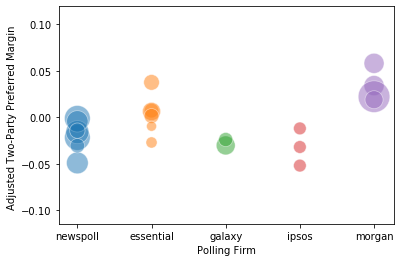

In [4]:
polls = pd.read_csv('../data/polls2019.csv').drop(['next_election', 'days_to_next'], axis=1)
polls['tpp_adjusted'] = polls['tpp_margin'] -  polls['bias']
ax = sns.scatterplot(x='firm', y='tpp_adjusted', size='std', hue='firm', sizes=(100,1000), alpha=0.5, legend=False, data=polls, )
ax.set(xlabel = "Polling Firm", ylabel="Adjusted Two-Party Preferred Margin ")
print("Mean polling two-party preferred margin: {:.3f} (ALP Win)".format((polls['tpp_adjusted'].mean())))
print("Actual two-party preferred margin: {:.3f} (COA Win)".format((51.53-48.47)/100))

<b>We are trying to combine these polls into a single _probabilistic_ estimate of the two-party preferred vote.</b>

Each dot represents a poll.
Across the x-axis are the five pollsters included in the forecast

On the y-axis is the _adjusted_ two-party preferred margin. I have adjusted this based on the historical accuracy of each pollster a similar time out from the election. The size of the bubble reflects the standard deviation of that historical accuracy. 

You can note the simple average of these values above. As well as the actual result which is way off the top of the y-axis. 

#### What is the universe of possible two-party preferred margins?

In [5]:
with pm.Model() as tpp_model:
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1)
    tpp_prior = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2690.02draws/s]


So here we start building our first PyMC3 model. PyMC3 uses the with contexts to hold its models together and keep track of which variables are added to which models. 
In this first line we have a uniform distribution that spans from -1, where the ALP would have 100% of the two-party preferred vote, to 1 where the Coalition would have 100% of the vote. 

We run this and let PyMC3 do it's MCMC magic. 

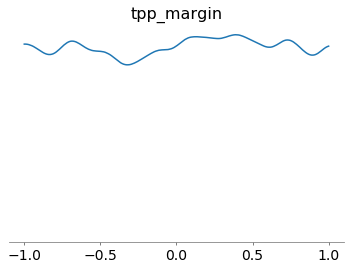

In [6]:
fig, ax = plt.subplots(1,1)
_ = az.plot_posterior(tpp_prior, combined=True, credible_interval=0.8, point_estimate=None, ax=ax)

- This is a probability density function.
- Along the x-axis are all the possible values of the two-party preferred margin. 
- The y-axis represents the relative probability of the different values
- You can see here that all values from -1 to 1 have similar probabilities because we haven't included any data in the model yet.

#### We can ask some questions of this prior, before our model has seen any data. 
What is the probability the Coaltion win the two-party preferred vote?

In [7]:
print("Coalition win two-party preferred vote: {:.2f}% of samples".format((tpp_prior['tpp_margin'] > 0).mean()*100))
print("Labor win two-party preferred vote: {:.2f}% of samples".format((tpp_prior['tpp_margin'] < 0).mean()*100))

Coalition win two-party preferred vote: 51.52% of samples
Labor win two-party preferred vote: 48.48% of samples


#### Specify a likelihood and add some data

In [8]:
with pm.Model() as tpp_model:
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])
    trace = pm.sample(draws=1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2641.35draws/s]


> Likelihood: expresses how likely particular values of statistical parameters are for a given set of observations

Coalition win TPP vote: 0.25%
Labor win TPP vote: 99.75%


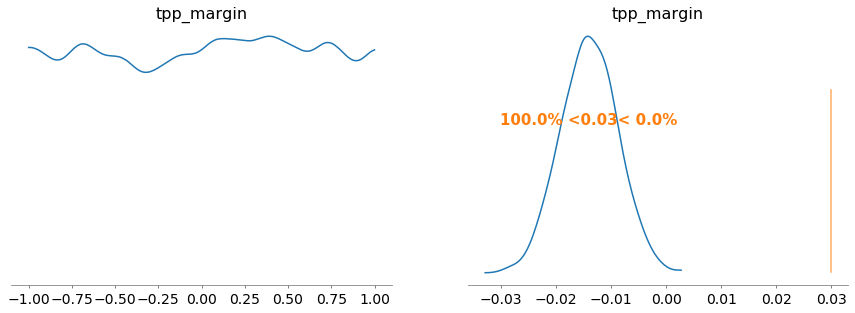

In [9]:
print("Coalition win TPP vote: {:.2f}%".format((trace['tpp_margin'] > 0).mean()*100))
print("Labor win TPP vote: {:.2f}%".format((trace['tpp_margin'] < 0).mean()*100))
fig, ax = plt.subplots(1,2, figsize=[15, 4.8])
_ = az.plot_posterior(tpp_prior, combined=True, credible_interval=0.8, point_estimate=None, ax=ax[0]) 
_ = az.plot_posterior(trace, combined=True, credible_interval=0.8, point_estimate=None, ax=ax[1], round_to=2, ref_val=0.03)

### Can we take this shoddy estimate of the two-party preferred vote and still use it to forecast the election?

Here we've got two plots. 

On the left is our original prior. Note the x axis goes all the way from -1 to 1. 

On the right is our "posterior" distribution, the estimate guven after we've shown the model our data.
- Note that the axis only spans from -0.03 to 0.03, so we're not assigning any probability to outcomes outside that range
- I've noted the actual result from the election: the Coalition winning with a margin of 3% (51.5% to 48.5%)
- You can see our estimate doesn't give any probability to the actual two-party preferred outcome
- I'll discuss this a little more later but it mostly reflects the inaccuracies of polling
- This gives an idea of what we predict the two-party preferred vote will be, can we still use it to predict the number of seats each party will win at an election?

### From the two-party preferred vote to the seats a party will win (Bayesian linear regression)

<img src="../img/model-overview-3.svg">

#### Look at the data: Historical election results

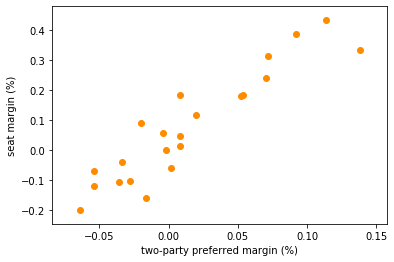

In [10]:
past_elections = pd.read_csv('../data/election_data.csv', index_col='date')
past_elections = past_elections.tail(22)
# past_elections[['tpp_margin', 'seat_margin_pc_majors']].tail()
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color="darkorange")
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seat margin (%)")

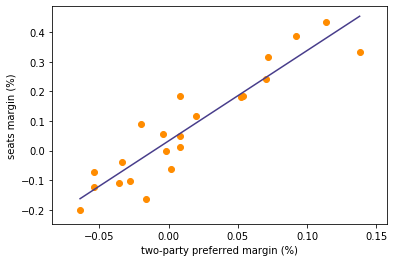

In [11]:
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color="darkorange")
_ = plt.plot(np.unique(past_elections['tpp_margin']), np.poly1d(np.polyfit(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], 1))(np.unique(past_elections['tpp_margin'])),color="darkslateblue")
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

#### Fit a line. 
\begin{align}
\\y & = slope \times x +\ intercept\\
\\y & = 3.05 \times x +\ 0.03\\
\end{align}

#### Specify priors.

In [12]:
with pm.Model() as linreg_model:
    slope = pm.Normal('slope', 0, sd=10)
    intercept = pm.Normal('intercept', 0, sd=10)
    sigma = pm.HalfCauchy('sigma', 1)
    linreg_priors = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1859.65draws/s]


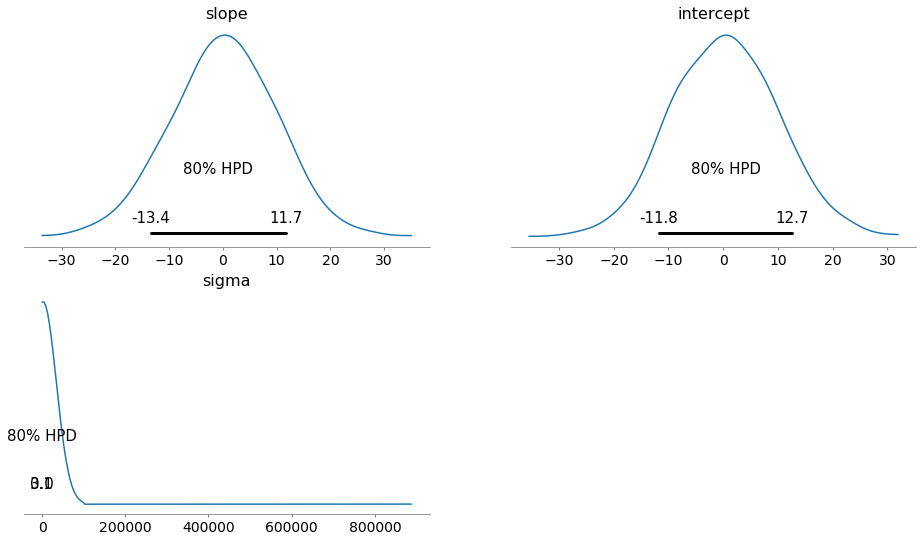

In [28]:
fig, ax = plt.subplots(2,2, figsize=[16,9])
_ = az.plot_posterior(linreg_priors, combined=True, credible_interval=0.8, point_estimate=None, ax=ax)
ax[1,1].set_visible(False)

#### Specify likelihood.

In [14]:
with linreg_model:
    y = intercept + slope * past_elections['tpp_margin']
    # tpp2seat likelihood
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = sigma, 
                              observed = past_elections['seat_margin_pc_majors'])
    trace = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1167.69draws/s]


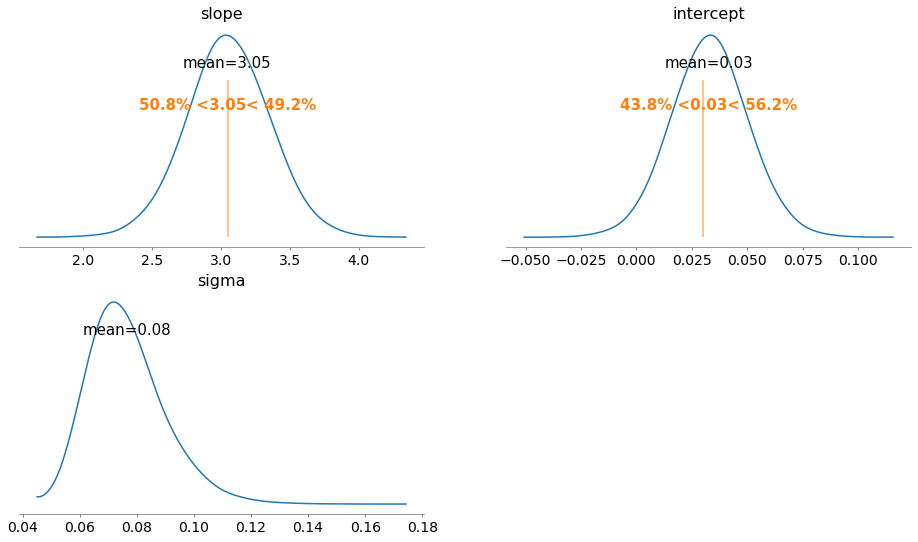

In [27]:
fig, ax = plt.subplots(2,2, figsize=[16,9])

 
ref_vals = {'slope': 3.05,
     'intercept': 0.03,
     'sigma': None}

axes = {'slope': (0,0),
     'intercept': (0,1),
     'sigma': (1,0)}
for var in ref_vals.keys():
    _ = az.plot_posterior(trace, var_names=var, combined=True, credible_interval=None, ax=ax[axes[var]], round_to=2, ref_val=ref_vals[var])
ax[1,1].set_visible(False)

Here we've got 6 different figures. 
On the left we have our prior distributions which we assigned earlier. 
On the right we have our posterior distributions. 

You can note that in every case the range of the x axis is markedly decreased. 

You might have also noticed that our mean estimates for slope and intercept are almost exactly the same as our line of best fit estimates. The great thing now is that instead of single best estimates we have probability distributions associated with our estimates. 

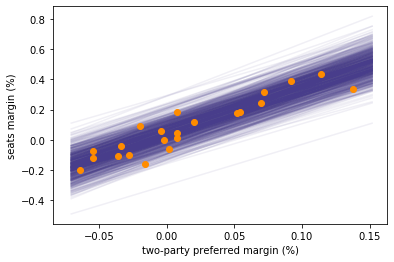

In [15]:
df = pm.trace_to_dataframe(trace)
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color='darkorange', zorder=501)

for i in range(700):
    line_x = pd.DataFrame([past_elections['tpp_margin'].min()*1.1, past_elections['tpp_margin'].max()*1.1])
    line_y = line_x * df.loc[i,'slope'] + df.loc[i,'intercept'] + np.random.normal(loc=0.0, scale=df.loc[i,'sigma'])
    _ = plt.plot(line_x, line_y, color='darkslateblue', alpha=0.08, zorder=500-i)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")

This is the same scatter plot you've seen before. Underneath the data points, I've plotted 700 lines derived from samples of the posterior distribution. You can see that our specified parameters do a good job covering the data points with more lines gathered underneath the central data points and fewer lines on the extremities, perhaps less likely outcomes. 

### Crossbench (homework)

In [18]:
crossbench_stats = pd.read_csv('../data/crossbench_stats.csv', index_col=0)
with pm.Model() as all_together:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)

A key part of the model that I'm not going to cover today is estimating the number of people who will sit on the crossbench. 

This is a tricky problem because there isn't much/any polling information available. 

I don't have time to cover it in this talk but you can have a look at the slides/notebook and see how it's done. 

Suffice to say, we go through the same process we've done twice today: specify priors, define a likelihood, and input the data. Unlike the two previous sections of the model, I use a slightly different Binomial likelihood to estimate the crossbench

### Putting it all together

<img src="../img/model-overview-4.svg">

In [19]:
with all_together:
    # aggregate polls
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])

    #estimate relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    sigma = pm.HalfCauchy('sigma', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = sigma, 
                              observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # combine tpp_margin estimate with our linear relationship
    seat_margin_pc = pm.Normal('seat_margin_pc', 
                               intercept + slope * tpp_margin, 
                               sd = sigma) #combine estimates
    
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))

    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    trace = pm.sample(draws=5000,tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [seat_margin_pc, sigma, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:45<00:00, 525.25draws/s]
The number of effective samples is smaller than 25% for some parameters.


Here's all the bits and pieces we've been through already in one place. Most of this code you've already seen. 

First, we specify our prior for the two-party preferred margin, then we update that prior with polling data to generate our estimate. 

Then we specify our priors for the linear relationship between two-party preferred margin and seat margin, then we update those priors using the data. 

Line 20 is a really key line, that's where we take the estimates from those two seperate estimates and combine them together. So we take our estimate of the two-party preferred margin from polling data and our estimates of slope, intercept and sigma and combine them all together. 

The last 6 lines of code are just math to resolve the actual number of seats ear party will win. 

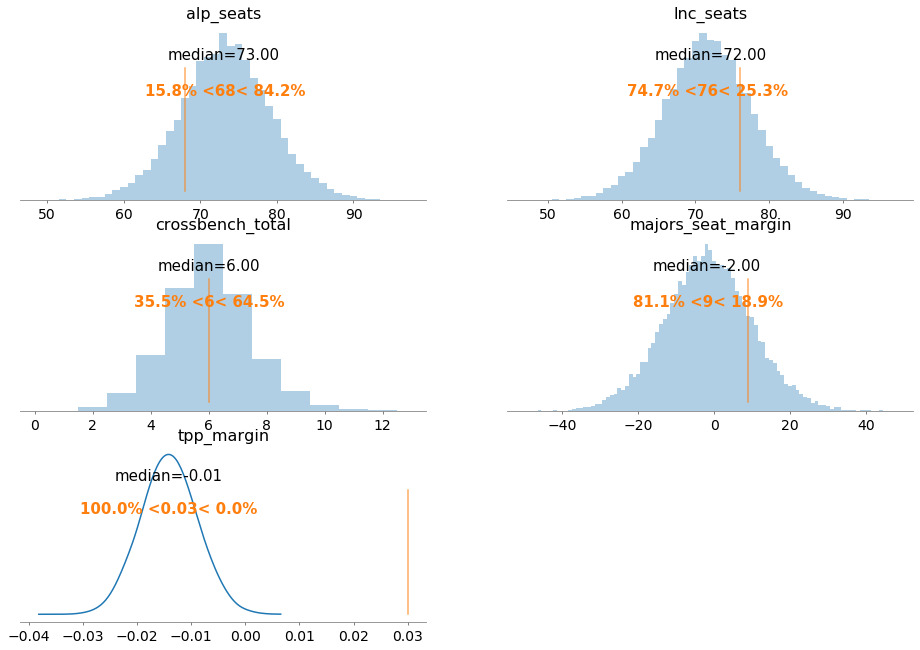

In [25]:
fig, ax = plt.subplots(3,2, figsize=[16,11])
ref_vals = {'alp_seats': 68,
            'lnc_seats': 76,
            'crossbench_total': 6,
            'majors_seat_margin':9,
            'tpp_margin': 0.03}

axes = {'alp_seats': (0,0),
        'lnc_seats': (0,1),
        'crossbench_total': (1,0),
        'majors_seat_margin':(1,1),
        'tpp_margin': (2,0)}

for var in ref_vals.keys():
    _ = az.plot_posterior(trace, var_names=var, point_estimate='median', credible_interval=None, ax=ax[axes[var]], round_to=2, ref_val=ref_vals[var])
ax[2,1].set_visible(False)

## Who will win?
 <img src="../img/model-overview-full.svg">

In [26]:
print("Coalition win majority: {:.2f}%".format((trace['lnc_seats'] >= 76).mean()*100))
print("ALP win majority: {:.2f}%".format((trace['alp_seats'] >= 76).mean()*100))
print("Minority government (neither party wins absolute majority): {:.2f}%".format(((trace['lnc_seats'] <76 ) & (trace['alp_seats'] < 76)).mean()*100))

Coalition win majority: 25.30%
ALP win majority: 34.80%
Minority government (neither party wins absolute majority): 39.90%


Sometimes unlikely things happen. If you flip a coin twice and get heads both times, that's the same chance our forecast had of the Coalition winning the election. If we take an umbrella on a day with a 25% chace of rain, we should be surprised when the Coalition won. 

We can take a pretty crap estimate of the two-party preferred margin but because we estimate uncertainty in other parts of the model, our end result isn't too far off. 

We didn't "predict" the Coalition would win, we assigned 

# Thanks!!

> Sometimes something other than the most likely outcome happens

## Free Resources

[ThinkBayes](https://greenteapress.com/wp/think-bayes/) by [Allen Downey](https://greenteapress.com/wp/think-bayes/)

[Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) by Cameron Davidson-Pilon

## Me

[Buckley's & None](https://www.buckleysandnone.come)

[/martintburgess](https://twitter.com/martintburgess)

[Nous](https://www.nousgroup.com/)
